# BLA Pyramidal Cell LFP
In this notebook we will investigate the contributions to the LFP of a stylized pyramidal cell from BLA. We will provide rhythmic synaptic input and compare the outcome to the detailed morphological reconstruction.

In [1]:
%pylab inline
import LFPy
import scipy
numpy.random.seed(12512)

Populating the interactive namespace from numpy and matplotlib
Failed to setup nrnpy_pr


/home/ben/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Create cell

In [2]:
cellParameters = {
    'morphology': 'Henckens_AM-C1A.swc',
    'templatefile': ['Henckens_AM-C1A_LFPytemplate.hoc'],
    'templatename': 'Henckens_AMC1A',
    'passive_parameters':{'g_pas':1./30000,'e_pas':-70.},
    'tstart' : 0,
    'tstop' : 60,
    'dt' : 2**-4,
    'passive': False,
    'nsegs_method': 'fixed_length',
    'max_nsegs_length':5,
    'cm':0.5,
    'Ra':150,
    'v_init':-70.,
    'celsius':31.,
    'pt3d':True,
    'verbose':True
}




# Define electrode parameters
# Create a grid of measurement locations, in (mum)
X, Z = np.mgrid[-350:351:100, -450:651:100]
Y = np.zeros(X.shape)
electrodeParameters = {
    'sigma' : 0.3,      # extracellular conductivity
    'x' : X.flatten(),  # electrode requires 1d vector of positions
    'y' : Y.flatten(),
    'z' : Z.flatten()
}

In [3]:
# Delete old sections
LFPy.cell.neuron.h("forall delete_section()")

# Create cell and print the variables belonging to it.
cell = LFPy.TemplateCell(**cellParameters)
cell.set_pos(x=0, y=0, z=0)
cell.set_rotation(x=np.pi/2.,z=np.pi)#z=np.pi

#from pprint import pprint
#print(pprint(vars(cell)))

# Add Synapses
Now we will place the synapses along the apical dendrite. 

In [4]:
num_syns = 1

SynapseParametersExc = {
    'syntype' : 'Exp2Syn',
    'e' : -50,
    'tau1' : 0.83,
    'tau2' : 6.27,
    'weight' : 0.018,
    'record_current' : True,
}

#SynapseParametersInh = {
#    'syntype' : 'Exp2Syn',
#    'e' : -80,
#    'tau1' : 0.83,
#    'tau2' : 6.27,
#    'weight' : 0.018,
#    'record_current' : True,
#}

# Synapse
synapse1 = LFPy.Synapse(cell,
                       idx = cell.get_closest_idx(x=63,z=0),
                       **SynapseParametersExc)

# Synapse will be applied at the times in array()
synapse1.set_spike_times(array([50])) 

#synapse2 = LFPy.Synapse(cell,
#                        idx = cell.get_closest_idx(x=0,z=0),
#                      **SynapseParametersInh)

#synapse2.set_spike_times(array([52,56,60,64,68,72])) 


# Set electrode
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# Simulate
First is a function to record the dendrite membrane potential.

In [5]:
import neuron

cell.simulate(electrode=electrode,
              rec_imem=True,
              rec_ipas=True,
              rec_icap=True,
              rec_vmem=True,
              rec_current_dipole_moment=True)

# Plot results
Figure 1 is a plot of the geometry of the cell, the location of the electrodes, location of the synapses, and the extracellular potential.

/home/ben/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


'\n# electrode 5 is at 0,100\nh = np.zeros((5,1))\nl = np.zeros((5,1))\nr = np.zeros((5,1))\n\nfor i in np.arange(0,5):\n    h[i,0] = electrode.z[5]-cell.zend[i]\n    l[i,0] = electrode.z[5]-cell.zstart[i]\n    r[i,0] = electrode.x[5]-cell.xstart[i]\n\ndist = np.log((np.sqrt(h**2+r**2)-h)/(np.sqrt(l**2+r**2)-l))\nv_ext=1000*(1/(4*np.pi*300*5))*np.dot(np.transpose(cell.imem),dist)\n'

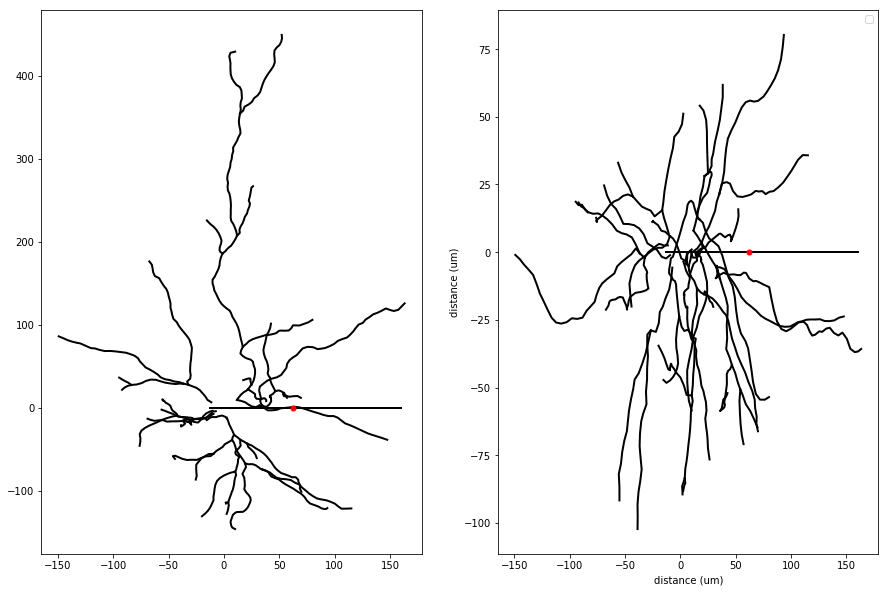

In [6]:
figure(figsize=(15, 10))
#subplot(2,3,4)



# Plot geometry of the cell
for sec in LFPy.cell.neuron.h.allsec():
    idx = cell.get_idx(sec.name())
    ax1=subplot(1,2,1)
    if sec.name()=="soma[0]":
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.zstart[idx], cell.zend[idx][-1]],
            'k',linewidth=8)
    else:
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.zstart[idx], cell.zend[idx][-1]],
            'k',linewidth=2)
        
    ax2=subplot(1,2,2)
    if sec.name()=="soma[0]":
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.ystart[idx], cell.yend[idx][-1]],
            'k',linewidth=8)
    else:
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
            np.r_[cell.ystart[idx], cell.yend[idx][-1]],
            'k',linewidth=2)
# Plot synapses as red dots
for i in np.arange(0,num_syns):
    subplot(1,2,1)
    plot([cell.synapses[i].x], [cell.synapses[i].z], color=[1,0,0], marker='o', markersize=5)
    subplot(1,2,2)
    plot([cell.synapses[i].x], [cell.synapses[i].y], color=[1,0,0], marker='o', markersize=5)
# Plot electrodes as green dots
#plot(electrode.x, electrode.z, '.', marker='o', color='g',label='electrodes')
#for i in np.arange(0,electrode.x.shape[0]):
#    plt.text(electrode.x[i]+10,electrode.z[i]-5,'{}'.format(i))

xlabel('distance (um)')
ylabel('distance (um)')
#ax1.set_ylim(-100,100)
#ax1.set_xlim(-300,-200)
#ax2.set_ylim(-400,300)
#ax2.set_xlim(-500,0)

legend()

        
#### Calculate extracellular potential by hand
'''
# electrode 5 is at 0,100
h = np.zeros((5,1))
l = np.zeros((5,1))
r = np.zeros((5,1))

for i in np.arange(0,5):
    h[i,0] = electrode.z[5]-cell.zend[i]
    l[i,0] = electrode.z[5]-cell.zstart[i]
    r[i,0] = electrode.x[5]-cell.xstart[i]

dist = np.log((np.sqrt(h**2+r**2)-h)/(np.sqrt(l**2+r**2)-l))
v_ext=1000*(1/(4*np.pi*300*5))*np.dot(np.transpose(cell.imem),dist)
'''


electrode 0 color: [0.         1.         0.73529412]
electrode 1 color: [0.         1.         0.34313725]
electrode 2 color: [0.01960784 1.         0.        ]
electrode 3 color: [0.31372549 1.         0.        ]
electrode 4 color: [0.3627451 1.        0.       ]
electrode 5 color: [0.16666667 1.         0.        ]
electrode 6 color: [0.         1.         0.14705882]
electrode 7 color: [0.         1.         0.53921569]
electrode 8 color: [0.         1.         0.93137255]
electrode 9 color: [0.         0.90196078 1.        ]
electrode 10 color: [0.         0.80392157 1.        ]
electrode 11 color: [0.         0.60784314 1.        ]
electrode 12 color: [0.         1.         0.58823529]
electrode 13 color: [0.         1.         0.09803922]
electrode 14 color: [0.46078431 1.         0.        ]
electrode 15 color: [0.95098039 1.         0.        ]
electrode 16 color: [1.         0.92058824 0.        ]
electrode 17 color: [0.90196078 1.         0.        ]
electrode 18 color: [0.

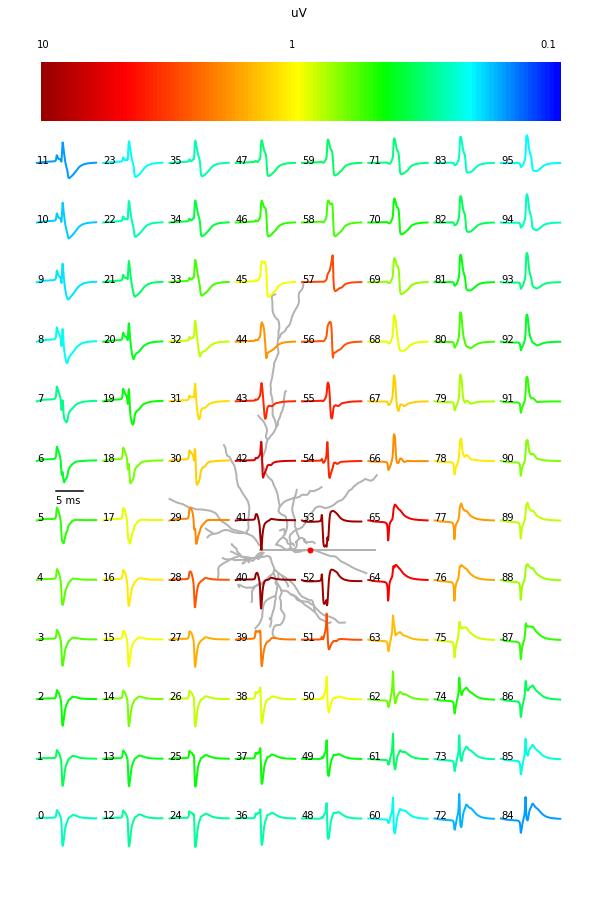

In [7]:
from utils import plot_ex2,plot_elec_grid_stick
fig = plot_elec_grid_stick(cell,electrode)
#fig.savefig('detailedpyrsynapseelecs_nobackprop.svg',bbox_inches='tight',pad_inches=0)

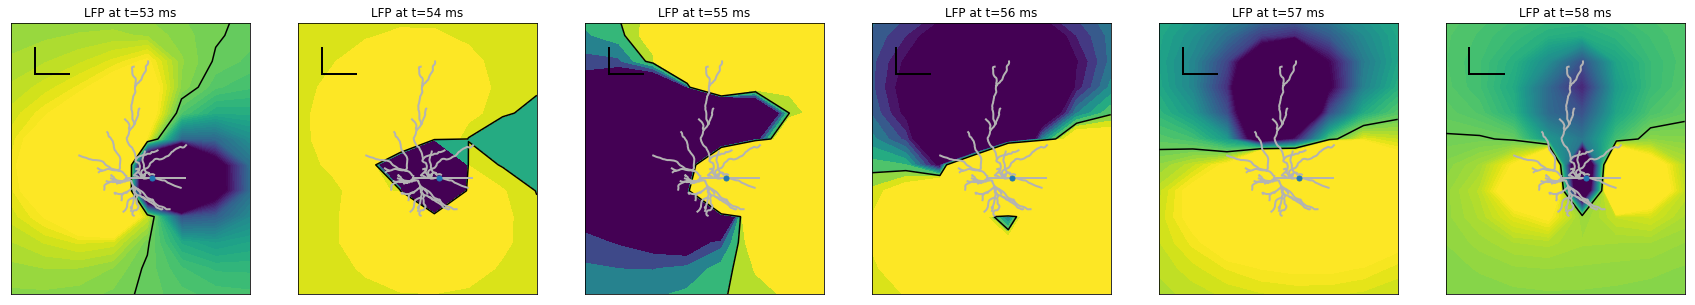

In [8]:
from utils import plot_ex1, plot_vmem_heat
fig = plot_ex1(cell, electrode, X, Y, Z, time_show=[53,54,55,56,57,58], space_lim = [-350,350,-450,600])

83.86985651799836
84.80761283653104
86.7236752333321
88.9475734612962


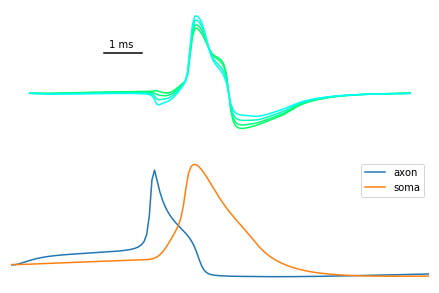

In [13]:
electrodes = [59,71,83,95]
elec_cols = [[0,1,0.39],[0,1,0.49],[0,1,.735],[0,1,.98]] # backprop
#elec_cols = [[0,0.0196,1],[0,0.0196,1],[0,0.0196,1],[0,0.0196,1]]
colors = np.zeros((120,3))
for i in np.arange(0,120):
    if i<20 and i>=0:
        colors[i,:] = [150 + 5.5*i,0,0] #Dark red to red
    elif i<40 and i>=20:
        colors[i,:] = [255,(i-19)*6,0] # Red to orange
    elif i<60 and i>=40:
        colors[i,:] = [255,120+(i-39)*6.75,0] # Orange to yellow
    elif i<80 and i>=60:
        colors[i,:] = [255-(i-59)*12.5,255,0] # yellow to green
    elif i<100 and i>=80:
        colors[i,:] = [0,255,(i-79)*12.5] # green to blue-green
    else:
        colors[i,:] = [0,255-(i-99)*12.5,255] # blue-green to blue
            
fig = plt.figure(figsize=[7.5, 5],frameon=False)    
ax=subplot(2,1,1)
c=0
for j in electrodes:
    LFP = electrode.LFP[j]
    tvec = cell.tvec[cell.tvec>50]
    zscore = LFP[cell.tvec>50]/(np.max(LFP[cell.tvec>50])-np.min(LFP[cell.tvec>50]))
    color_ind = 10*np.abs(np.log(np.max(LFP[cell.tvec>50])-np.min(LFP[cell.tvec>50])))
    print(10*np.abs(np.log(np.max(LFP[cell.tvec>50])-np.min(LFP[cell.tvec>50]))))
    plot(tvec,zscore,color=elec_cols[c])
    c+=1
    
plot([52,53],[0.4,0.4],'k')
text(52.13, 0.45,'1 ms')
    
ax2=subplot(2,1,2)
colors = ['r','g','b','m','k']
axon = 285
soma = 0
#for i in np.arange(0,cell.vmem.shape[0]):
 #   print(i)
    #if mod(i,15)==0:
        #plot(cell.tvec,cell.vmem[i,:],label="{}".format(i))
plot(cell.tvec,cell.vmem[-10,:],label="axon")
#plot(cell.tvec,cell.vmem[30,:])
plot(cell.tvec,cell.vmem[soma,:], label="soma")
#peak = np.max(cell.vmem[i])
legend()
xlim(50,60)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.axis('off')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.axis('off')

fig.savefig('detailedspike_backprop_intraextra.svg',bbox_inches='tight',pad_inches=0)

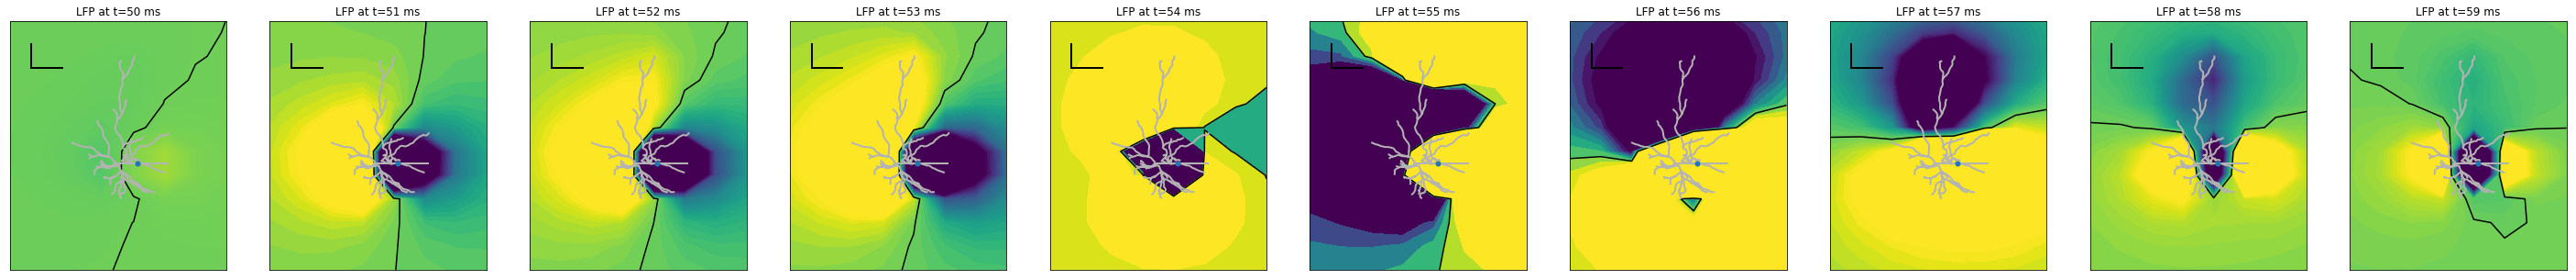

In [10]:
from utils import plot_ex1, plot_vmem_heat
#fig = plot_ex2(cell, electrode, X, Y, Z, time_show=[50,51,52,53,54,55])
#zoom1=[-450,0,-200,500]
fig = plot_ex1(cell, electrode, X, Y, Z, time_show=[50,51,52,53,54,55,56,57,58,59], space_lim = [-350,350,-450,600])
#fig.savefig('AM-C1A_LFP_zoom2.svg')

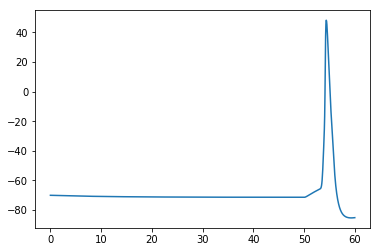

In [11]:
plot(cell.tvec,cell.somav)


## Visualize synaptic inputs
Let's get an idea of what the synaptic spike times look like. First we need to convert the spike times to a one dimensional array.

In [12]:
st_1darr = np.zeros((100000,))

start = 0
stop = syn_spike_times[0].shape[0]
for i in np.arange(0,len(syn_spike_times)-1):
    st_1darr[start:stop] = syn_spike_times[i]
    start = stop
    stop = start + syn_spike_times[i+1].shape[0]

NameError: name 'syn_spike_times' is not defined

In [ ]:
n_bins = cellParameters['tstop']/10

time = np.arange(0,cellParameters['tstop'],cellParameters['tstop']/n_bins)
figure(figsize=(12,12))
X=np.histogram(st_1darr[st_1darr!=0],bins=n_bins)

for i in np.arange(0,len(syn_spike_times)):    
    subplot(2,1,1)
    plot(syn_spike_times[i],np.tile(i, syn_spike_times[i].shape[0]),'b.')

ylabel('cell ID')
xlabel('time(ms)')
xlim(100,1000)
twinx()

bin_time = (cellParameters['tstop']/n_bins)/1000.0
plot(time,(X[0]/bin_time)/num_syns,'r',label='firing rate')
ylabel('avg. firing rate (Hz)')
legend()
    
from scipy.signal import welch
from scipy.signal.windows import hann

fs = n_bins
nblock = n_bins/4
overlap = 2
win = hann(nblock, True)

f, Pxxf = welch(X[0], fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)

subplot(2,1,2)
semilogy(f,Pxxf)
ylabel('power')
xlabel('frequency (Hz)')

## Extracellular potential traces
We created 21 electrodes. Here we will plot the extracellular potential recorded from them. The large spikes are extracellular action potentials. We then lowpass filter and downsample the signal to 1000 Hz to get the true LFP.

In [ ]:
from scipy import signal
def low_pass_filt(cutoff,fs,data):
    b, a = signal.butter(2, float(cutoff)/float(fs/2), 'low')
    return signal.filtfilt(b, a, data)
 
LFP = np.zeros((electrode.LFP.shape[0],cellParameters['tstop']+1))
    
# Plot the extracellular potential from all of the electrodes in black with the LFP signal in red.
figure(figsize=(17,15))

for i in np.arange(0,electrode.LFP.shape[0]):
    ax=subplot(7,3,i+1)
    plot(cell.tvec,electrode.LFP[i,:],'k')
    y = low_pass_filt(500,16000,electrode.LFP[i,:])
    plot(np.arange(0,cellParameters['tstop']+1,1),y[::16],'r')
    LFP[i,:] = y[::16]
    xlim(1000,1100)


Now to look at the frequency domain. We will first downsample the signal to get rid of the action potentials.

In [ ]:
from scipy.signal import welch
from scipy.signal.windows import hann


fs = 1000
nblock = cellParameters['tstop']
overlap = 100
win = hann(nblock, True)


figure(figsize=(17,15))
print('FFT of LFP')
for i in np.arange(0,electrode.LFP.shape[0]):
    f, Pxxf = welch(LFP[i,:], fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)
    ax=subplot(7,3,i+1)
    semilogy(f,Pxxf)
    xlim(0,200)

#ylim(10e-14,10e-10)
#savefig('FFT.svg')

In [ ]:
fig=figure(figsize=(12,10))
ax1 = plt.subplot(111)
# inset
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(cell.tvec,cell.somav, color='blue')
xlim(2025,2030)
# main plot
ax1.plot(cell.tvec,cell.somav,label='soma',color='blue')
c=0
for x in dendvreclist:
    c = c+1
    y = np.array(x)
    if c==1:
        ax1.plot(cell.tvec,y,label='dend',color=[0,1,0])
        ax2.plot(cell.tvec,y,label='dend',color=[0,1,0])
    else:
        ax1.plot(cell.tvec,y,label='axon',color=[1,0,0])
        ax2.plot(cell.tvec,y,label='axon',color=[1,0,0])
ax1.set_ylim(-72,20)
ax1.legend()
title('mem. potential (mV)')